# Академия Аналитиков Авито

# Эконометрика

Общий план курса:
- Повторение теории вероятности и математической статистики
- Классическая линейная регрессия
- Множественная регрессия
- Метрики качества регрессии и проверка гипотез, связанных с ней
- **Нарушение предпосылок теоремы Гаусса-Маркова**
- Модели бинарного выбора
- Временные ряды

# Занятие №6 

- На предыдущем занятии мы

- Поговорили про гетероскедастичность

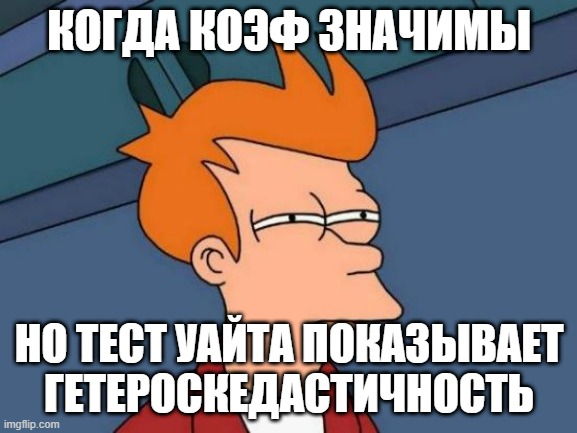

- Научились ее обнаруживать и бороться с ней

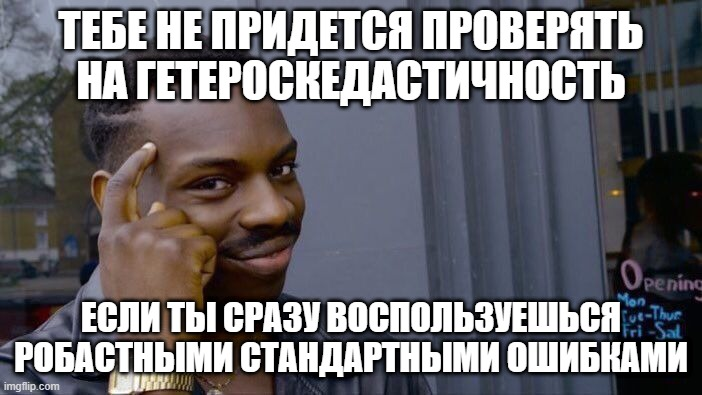

- Поняли, как интерпретировать коэффициенты в логарифмических моделях

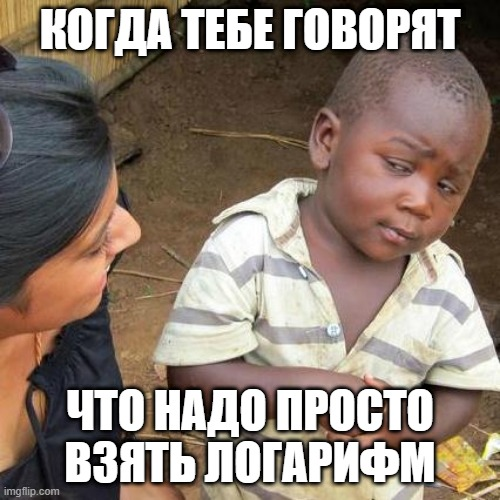

## Пакеты

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy as sp

import statsmodels.formula.api as smf
import statsmodels.api as sm

- Одной из важнейших предпосылок теоремы Г.-М. была предпосылка, что $X$ детерминированы, т.е. не случайны
- Однако, в реальности, это, конечно, же не так
- Самой простой пример, который можно привести, это ошибка измерения $X$. Вспомните, что разметка на линейке может отличаться от разметки на другой линейке
- Может возникнуть ситуация, когда "случайность"  $X$ связана со "случайностью" модели. Грубо говоря, $X$ становятся эндогенными, и $cov(X, \varepsilon) \ne 0$

In [2]:
np.random.seed(123)

another_rv = np.random.normal(loc = 0, scale = 1, size = 1000)

X1 = another_rv + np.random.normal(loc = 0, scale = 2, size = 1000)
X2 = another_rv + np.random.normal(loc = 0, scale = 3, size = 1000)

eps = np.random.normal(loc = 0, scale = 1, size = 1000)

Y = 10 + 2 * X1 + 4 * X2 + eps

df = pd.concat([pd.Series(X1, name = 'Experience'), 
                       pd.Series(X2, name = 'Study_result'),
                       pd.Series(Y, name = 'Salary')], axis=1)

# reshape

X1 = X1.reshape(X1.shape[0], 1)
X2 = X2.reshape(X2.shape[0], 1)
Y = Y.reshape(Y.shape[0], 1)

In [3]:
smf.ols('Y~X1', data = df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     212.5
Date:                Tue, 14 Mar 2023   Prob (F-statistic):           8.63e-44
Time:                        18:49:22   Log-Likelihood:                -3926.4
No. Observations:                1000   AIC:                             7857.
Df Residuals:                     998   BIC:                             7867.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0474      0.389     25.860      0.000       9.285      10.810
X1             2.6546      0.182     14.579      0.000       2.297       3.012
==============================================================================
Omnibus:                        1.741   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.419   Jarque-Bera (JB):                1.806
Skew:                          -0.097   Prob(JB):                        0.405
Kurtosis:                       2.924   Cond. No.                         2.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## План
- Эндогенность

## Эндогенность

### Определение

- Эндогенностью, обычно, в эконометрике называют ситуацию, когда объясняющие переменные являются коррелированными со случайным членом
- Если рассмотреть в более широком понятии, то эндогенной переменной считается та, которая определяется внутри модели, экзогенной - вне модели
- В целом, если удобнее и понятнее, то можно пользоваться первым определением

- **Причины эндогенности** можно кластеризовать следующим образом:
    - Пропущенные объясняющие переменные
    - Одновременные уравнения (не будем трогать в этом курсе)
    - Динамические модели (не будем трогать в этом курсе)
    - Ошибка измерения

#### Пропущенные объясняющие переменные  
- На самом деле у нас может быть две ситуации:
    - Мы упустили переменную, которая в модели должна быть
    - Мы добавили переменную, который в модели быть не должно
- Второй случай мало на что влияет: оценки коэффициентов все еще несмещенные, стандартные ошибки рассчитаны корректно, но более не являются эффективными (хотя и не всегда)
- Давайте рассмотрим первую ситуацию подробнее

- У нас есть некая истинная модель: $y = \alpha + \beta_1 * X_1 + \beta_2 * X_2 + \varepsilon$
- Мы же с вами посчитали модель: $\hat{y} = \hat{\alpha} + \hat{\beta_1} * X_1$
- Тогда наша оценка коэффициента $\hat{\beta_1}$ выглядит как:  
$$\hat{\beta_1} = \frac{cov(X_1, y)}{var(X_1)} = \frac{cov(X_1, \alpha + \beta_1 * X_1 + \beta_2 * X_2 + \varepsilon)}{var(X_1)} = \frac{\beta_1 * var(X_1) + \beta_2 * cov(X_1, X_2)}{var(X_1)} = \beta_1 + \beta_2 * \frac{cov(X_1, X_2)}{var(X_1)}$$
- Другими словами, если пропущенная переменная имееет нулевую корреляцию с текущей (а это, чаще всего, не так), то никакого смещения оценки коэффициента не будет
- Плюс, формулы для стандартных ошибок коэффициентов и тестовые статистики, вообще говоря, становятся некорректными

- Мы уже видели, что происходит при пропуске переменной на симулированных данных
- Теперь посмотрим на реальный набор данных
- Набор данных `EAEF` - это перекрестная выборка данных об обучении и заработке
- По сути, этот набор данных - это панельное обследование с повторяющимися опросами общенациональной репрезентативной выборки молодых мужчин и женщин в возрасте от 14 до 21 года с 1979 г.
- Данные перекрестных выборок представлены в виде 22 параллельных подмножеств, каждое из которых включает 540 наблюдений, в том числе 270 случайно выбранных респондентов
- Мы с вами будем использовать 21-й набор 

P.S. Данные и их описание взяты из `Доугерти К. Введение в эконометрику (издание 3). М., ИНФРА-М, 2010` и [отсюда](https://global.oup.com/uk/orc/busecon/economics/dougherty5e/student/datasets/eawe/excel/)

In [6]:
from jupyter_datatables import init_datatables_mode


init_datatables_mode()

<JupyterRequire.display.SafeScript object>

<JupyterRequire.display.SafeScript object>

<JupyterRequire.display.SafeScript object>

<JupyterRequire.display.SafeScript object>

<JupyterRequire.display.SafeScript object>

<JupyterRequire.display.SafeScript object>

<JupyterRequire.display.SafeScript object>

<JupyterRequire.display.SafeScript object>

In [4]:
df = pd.read_csv('practice_06_001.csv')

,ID,FEMALE,MALE,ETHBLACK,ETHHISP,ETHWHITE,AGE,S,EDUCPROF,EDUCPHD,EDUCMAST,EDUCBA,EDUCAA,EDUCHSD,EDUCDO,SINGLE,MARRIED,DIVORCED,FAITHN,FAITHP,FAITHC,FAITHJ,FAITHO,ASVAB01,ASVAB02,ASVAB03,ASVAB04,ASVAB05,ASVAB06,ASVABC,HEIGHT,WEIGHT85,WEIGHT02,SM,SF,SIBLINGS,LIBRARY,POV78,EXP,EARNINGS,HOURS,TENURE,COLLBARG,CATGOV,CATPRI,CATSE,URBAN,REGNE,REGNC,REGW,REGS
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
25%,1525.000000,0.000000,0.000000,0.000000,0.000000,1.000000,39.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,42.000000,44.000000,47.000000,46.000000,45.000000,44.542679,64.000000,129.000000,150.000000,11.000000,10.000000,2.000000,1.000000,0.000000,14.596154,10.757500,40.000000,1.937500,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2787.500000,0.500000,0.500000,0.000000,0.000000,1.000000,41.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,50.000000,50.000000,52.000000,53.000000,52.000000,51.000000,52.721268,67.000000,155.000000,180.000000,12.000000,12.000000,3.000000,1.000000,0.000000,17.509615,16.000000,40.000000,4.692308,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,4398.750000,1.000000,1.000000,0.000000,0.000000,1.000000,43.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,56.000000,58.000000,57.000000,56.000000,59.000000,57.000000,58.718899,71.000000,178.000000,210.000000,12.000000,14.000000,4.000000,1.000000,0.000000,20.197116,23.155000,45.000000,10.980769,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
count,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,513.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000
max,12110.000000,1.000000,1.000000,1.000000,1.000000,1.000000,45.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,68.000000,66.000000,61.000000,62.000000,62.000000,72.000000,66.079628,80.000000,322.000000,400.000000,20.000000,20.000000,13.000000,1.000000,1.000000,23.557692,120.190000,60.000000,24.942308,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000
mean,3330.190741,0.500000,0.500000,0.105556,0.051852,0.842593,40.918519,13.672222,0.007407,0.001852,0.051852,0.194444,0.088889,0.548148,0.077778,0.148148,0.657407,0.194444,0.046296,0.496296,0.320370,-0.003704,0.1
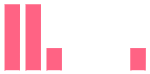
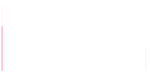
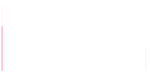
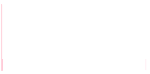
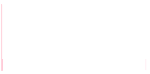
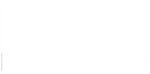
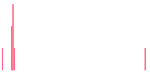
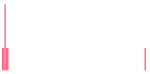
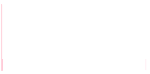
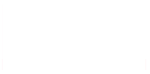
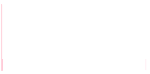
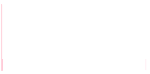
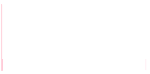
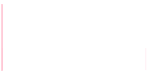
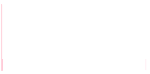
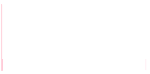
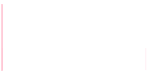
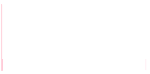
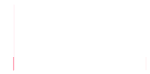
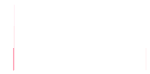
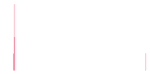
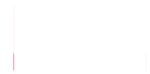
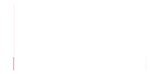
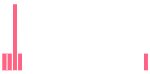
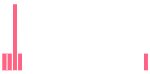
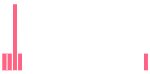
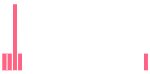
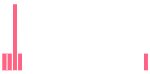
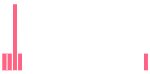
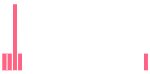
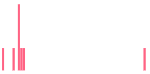
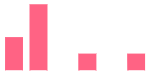
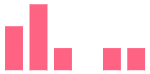
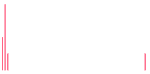
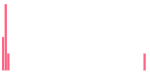
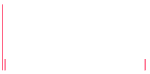
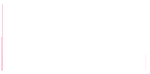
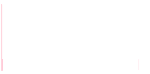
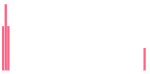
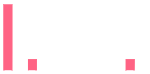
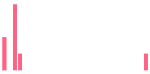
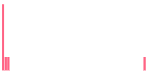
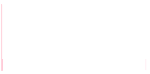
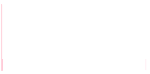
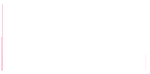
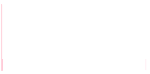
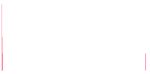
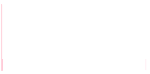
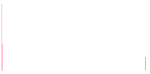
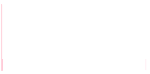
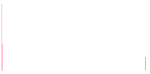
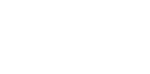
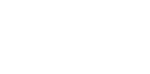
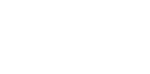
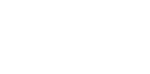
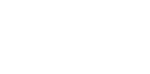
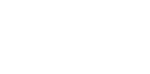
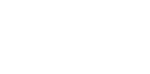
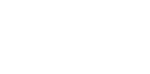
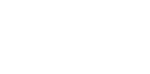
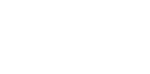
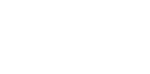
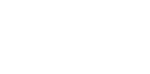
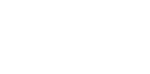
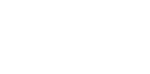
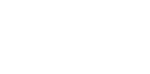
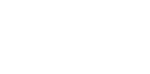
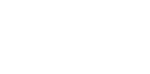
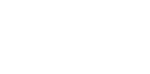
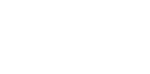
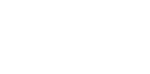
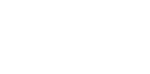
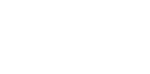
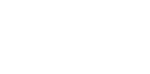
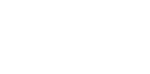
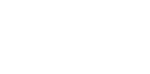
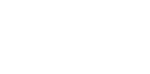
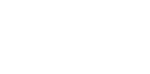
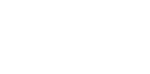
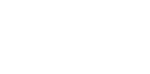
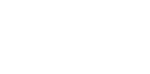
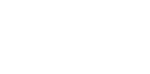
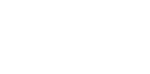
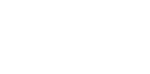
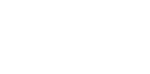
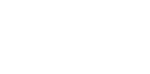
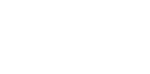
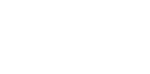
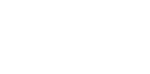
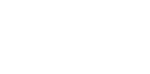
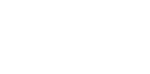
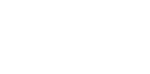
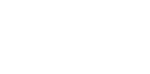
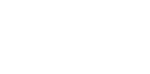
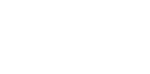
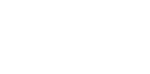
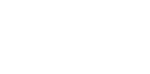
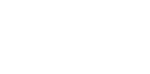
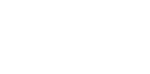
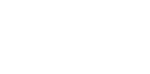
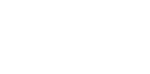
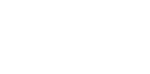

<JupyterRequire.display.SafeScript object>

,ID,FEMALE,MALE,ETHBLACK,ETHHISP,ETHWHITE,AGE,S,EDUCPROF,EDUCPHD,...,TENURE,COLLBARG,CATGOV,CATPRI,CATSE,URBAN,REGNE,REGNC,REGW,REGS
count,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,...,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000
mean,3330.190741,0.500000,0.500000,0.105556,0.051852,0.842593,40.918519,13.672222,0.007407,0.001852,...,7.033974,0.187037,0.227778,0.753704,0.018519,0.724074,0.142593,0.337037,0.157407,0.362963
std,2684.020191,0.500464,0.500464,0.307553,0.221933,0.364522,2.322918,2.438476,0.085826,0.043033,...,6.427247,0.390303,0.419787,0.431253,0.134942,0.483277,0.349981,0.473136,0.364522,0.481300
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.000000,7.000000,0.000000,0.000000,...,0.019231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1525.000000,0.000000,0.000000,0.000000,0.000000,1.000000,39.000000,12.000000,0.000000,0.000000,...,1.937500,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2787.500000,0.500000,0.500000,0.000000,0.000000,1.000000,41.000000,13.000000,0.000000,0.000000,...,4.692308,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,4398.750000,1.000000,1.000000,0.000000,0.000000,1.000000,43.000000,16.000000,0.000000,0.000000,...,10.980769,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,12110.000000,1.000000,1.000000,1.000000,1.000000,1.000000,45.000000,20.000000,1.000000,1.000000,...,24.942308,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
df.describe()


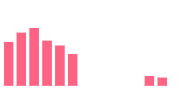
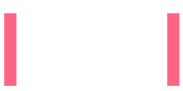
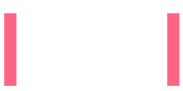
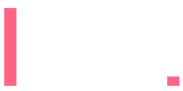
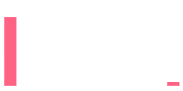
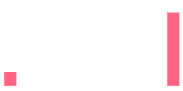
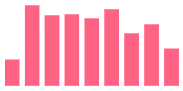
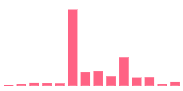
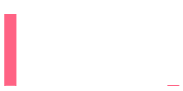
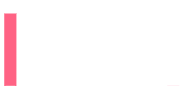
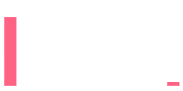
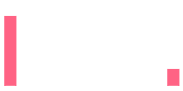
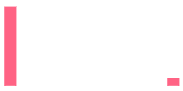
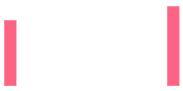
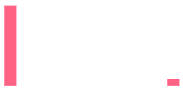
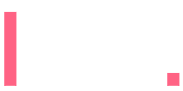
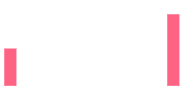
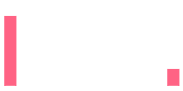
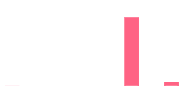
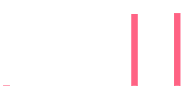
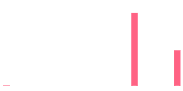
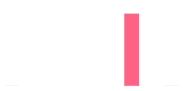
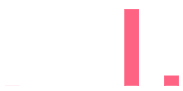
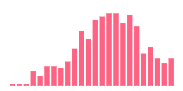
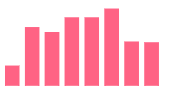
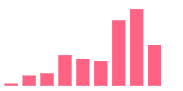
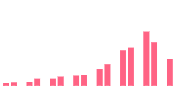
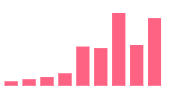
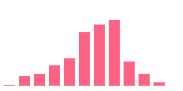
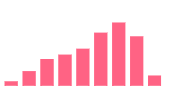
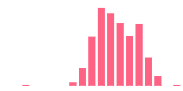
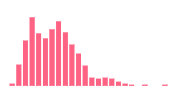
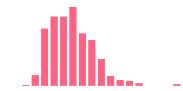
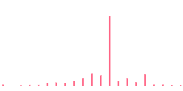
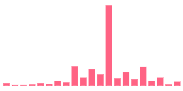
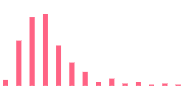
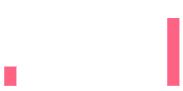
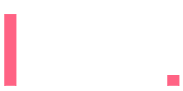
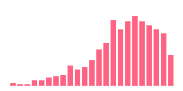
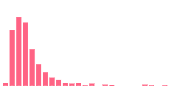
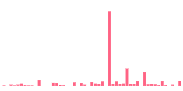
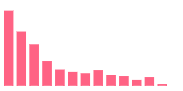
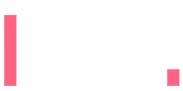
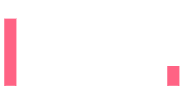
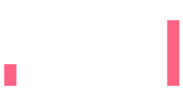
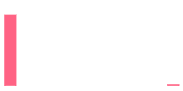
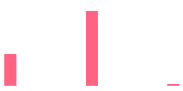
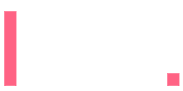
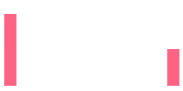
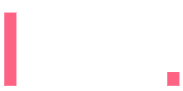
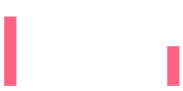
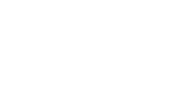
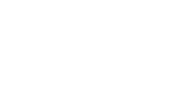
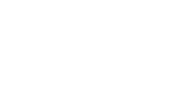
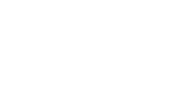
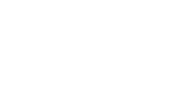
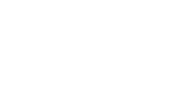
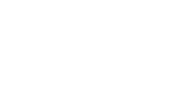
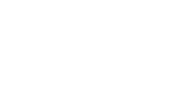
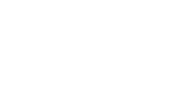
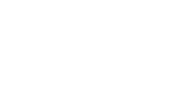
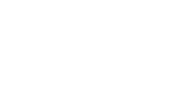
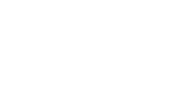
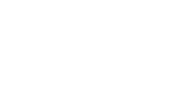
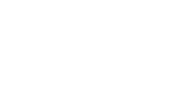
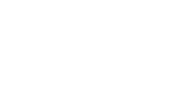
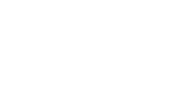
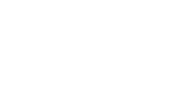
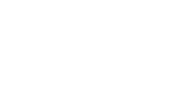
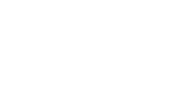
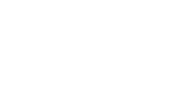
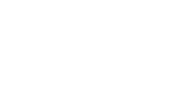
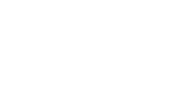
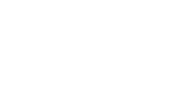
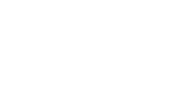
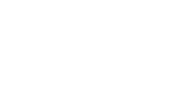
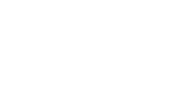
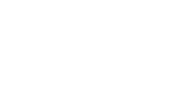
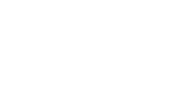
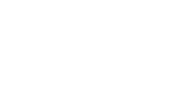
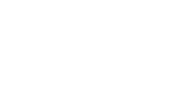
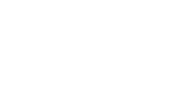
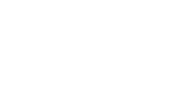
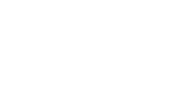
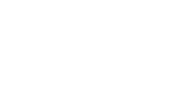
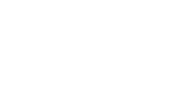
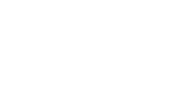
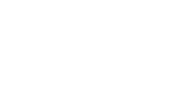
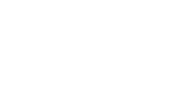
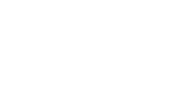
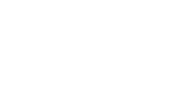
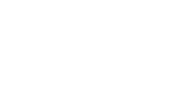
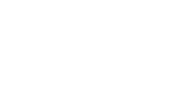
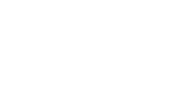
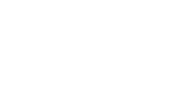
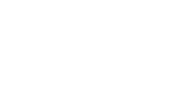
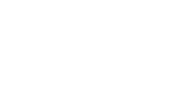
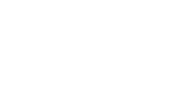
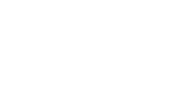
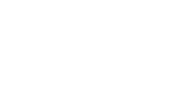
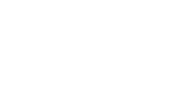
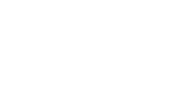

<JupyterRequire.display.SafeScript object>

,ID,FEMALE,MALE,ETHBLACK,ETHHISP,ETHWHITE,AGE,S,EDUCPROF,EDUCPHD,...,TENURE,COLLBARG,CATGOV,CATPRI,CATSE,URBAN,REGNE,REGNC,REGW,REGS
0,5531,0,1,0,0,1,45,12,0,0,...,2.750000,0,0,1,0,0,0,0,0,1
1,2658,0,1,0,1,0,40,12,0,0,...,2.384615,0,0,1,0,0,0,0,0,1
2,5365,0,1,0,0,1,38,15,0,0,...,5.750000,1,0,1,0,1,0,1,0,0
3,4468,0,1,0,0,1,43,13,0,0,...,6.134615,1,0,1,0,1,0,0,1,0
4,3142,0,1,0,0,1,38,18,0,0,...,0.826923,0,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,682,1,0,1,0,0,39,12,0,0,...,7.730769,0,1,0,0,1,0,1,0,0
536,1564,1,0,0,0,1,42,14,0,0,...,5.326923,0,0,1,0,1,0,0,1,0
537,4373,1,0,0,0,1,38,12,0,0,...,10.461538,0,0,1,0,1,0,0,1,0
538,1444,1,0,0,1,0,40,13,0,0,...,1.134615,0,0,1,0,1,0,0,0,1


In [7]:
df

In [10]:
df.columns

Index(['ID', 'FEMALE', 'MALE', 'ETHBLACK', 'ETHHISP', 'ETHWHITE', 'AGE', 'S',
       'EDUCPROF', 'EDUCPHD', 'EDUCMAST', 'EDUCBA', 'EDUCAA', 'EDUCHSD',
       'EDUCDO', 'SINGLE', 'MARRIED', 'DIVORCED', 'FAITHN', 'FAITHP', 'FAITHC',
       'FAITHJ', 'FAITHO', 'ASVAB01', 'ASVAB02', 'ASVAB03', 'ASVAB04',
       'ASVAB05', 'ASVAB06', 'ASVABC', 'HEIGHT', 'WEIGHT85', 'WEIGHT02', 'SM',
       'SF', 'SIBLINGS', 'LIBRARY', 'POV78', 'EXP', 'EARNINGS', 'HOURS',
       'TENURE', 'COLLBARG', 'CATGOV', 'CATPRI', 'CATSE', 'URBAN', 'REGNE',
       'REGNC', 'REGW', 'REGS'],
      dtype='object')

- Колонки
    - FEMALE - пол респондента (1 - если женщина, 0 - если мужчина)
    - MALE - пол респондента (0 - если женщина, 1 - если мужчина)
    - Этническое происхождение
        - ETHBLACK - темнокожие
        - ETHHISP - испаноязычные
        - ETHWHITE - не темнокожие и не испаноязычные
        - AGE - возраст
    - S - число полных лет обучения
    - Уровень образование
        - EDUCPROF - профессиональное образование
        - EDUCPHD - докторская степень
        - EDUCMAST - степень магистра
        - EDUCBA - степень бакалавра
        - EDUCAA - вспомогательное (двухлетний колледж) образование
        - EDUCHSD - окончена средняя школа или ее эквивалент
        - EDUCDO - незаконченное среднее
    - Состояние в браке
        - SINGLE - не состоит и никогда не состоял(а) в браке
        - MARRIED - состоит в браке, совместное проживание
        - DIVORCED - разведен(а) или проживает с супругом раздельно
    - Шкалированный результат по сотавляющим выполнения тестов на позновательные способности ASVAB
        - ASVAB02 - арифметические рассуждения
        - ASVAB03 - словарный запас
        - ASVAB04 - понимание смысла выражений
        - ASVAB05 - скорость выполнения простейших арифметических вычислений
        - ASVAB06 - скорость кодирования
        - ASVABC - общий результат теста, включая ASVAB02 (с двойным весом), ASVAB03 и ASVAB04
    - Вероисповедание
        - FAITHN - атеисты
        - FAITHP - протестанты
        - FAITHC - католики
        - FAITHJ - иудаисты
        - FAITHO - другие
    - HEIGHT - рост в дюймах в 1985 г.
    - WEIGHT85 - вес в фунтах в 1985 г.
    - WEIGHT02 - вес в фунтах в 2002 г.
    - Характеристики семьи
        - SM - продолжительность обучения матери респондента
        - SF - продолжительность обучения отца респондента
        - SIBLINGS - число братьев и сестер
    - Проживание в возрасте 14 лет
        - LIBRARY - наличие у одного из членов семьи читательского билета библиотеки, когда респондент был в возрасте 14 лет
        - POV78 - малообеспеченость в 1978 г.
    - Переменные, связанные с работой
        - EARNINGS - текущий часовой заработок в долларах США в 2002 г.
        - HOURS - обычное число рабочих часов в неделю в 2002 г.
        - TENURE - стаж работы (лет) у нынешнего работодателя в 2002 г.
        - EXP - общий стаж работы (лет) 
        - COLLBARG - уровень оплаты, установленный на переговорах работодателя с профсоюзом в 2002 г.
    - Категории занятости
        - CATGOV - гос. сектор
        - CATPRI - частный сектор
        - CATSE - самозанятость
    - URBAN - проживание в городе в 2002 г.
    - Проживание в 2002 г.
        - REGNC - северо-западный регион
        - REGNE - северо-восточный регион
        - REGS - южный регион
        - REGW - западный регион

- Давайте предположим, что истинная модель имеет вид: $S = \alpha + \beta_1 * \text{ASVABC} + \beta_2 * \text{SM} + \varepsilon$

- Посчитайте истинную модель
- Посчитайте корреляцию между переменными `ASVABC` и `SM`. Какой знак она имеет и чему равна? Как вы считаете, как будут смещены оценки коэффициентов в однофакторных регресиях для `ASVABC` и `SM`. 
- Посчитайте однофакторную модель с переменной:
    - `ASVABC`
    - `SM`
- Согласуется ли полученный результат с вашим предположением о том, как будут смещены коэффициенты

In [14]:
result_1 = smf.ols('S ~ ASVABC + SM', df).fit()
result_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     147.4
Date:                Tue, 14 Mar 2023   Prob (F-statistic):           9.66e-52
Time:                        18:57:22   Log-Likelihood:                -1128.9
No. Observations:                 540   AIC:                             2264.
Df Residuals:                     537   BIC:                             2277.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4207      0.493     10.995      0.000       4.452       6.389
ASVABC         0.1328      0.010     13.637      0.000       0.114       0.152
SM             0.1235      0.033      3.733      0.000       0.059       0.188
==============================================================================
Omnibus:                        8.774   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.975
Skew:                           0.301   Prob(JB):                       0.0113
Kurtosis:                       2.812   Cond. No.                         313.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

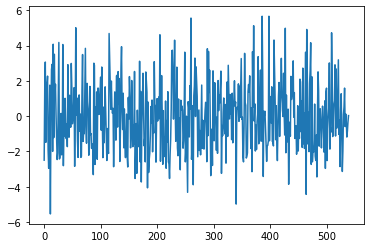

In [15]:
plt.plot(result_1.resid)

,S,ASVABC,SM
,float64,float64,float64
,,,
,float64,float64,float64
,,,
ASVABC,0.581025,1.000000,0.420196
S,1.000000,0.581025,0.361609
SM,0.361609,0.420196,1.000000

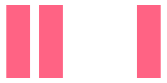
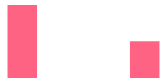
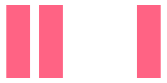
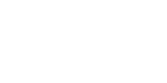
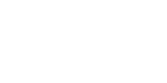
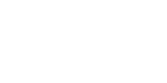

<JupyterRequire.display.SafeScript object>

,S,ASVABC,SM
S,1.000000,0.581025,0.361609
ASVABC,0.581025,1.000000,0.420196
SM,0.361609,0.420196,1.000000


In [24]:
df[['S', 'ASVABC', 'SM']].corr()

In [22]:
result_2 = smf.ols('S ~ ASVABC', df).fit()
result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     274.2
Date:                Tue, 14 Mar 2023   Prob (F-statistic):           4.51e-50
Time:                        19:01:46   Log-Likelihood:                -1135.9
No. Observations:                 540   AIC:                             2276.
Df Residuals:                     538   BIC:                             2284.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0662      0.467     12.983      0.000       5.148       6.984
ASVABC         0.1481      0.009     16.559      0.000       0.131       0.166
==============================================================================
Omnibus:                        9.072   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.317
Skew:                           0.310   Prob(JB):                      0.00948
Kurtosis:                       2.828   Cond. No.                         286.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
result_3 = smf.ols('S ~ SM', df).fit()
result_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     80.93
Date:                Tue, 14 Mar 2023   Prob (F-statistic):           3.99e-18
Time:                        19:02:20   Log-Likelihood:                -1209.2
No. Observations:                 540   AIC:                             2422.
Df Residuals:                     538   BIC:                             2431.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0469      0.415     24.226      0.000       9.232      10.862
SM             0.3131      0.035      8.996      0.000       0.245       0.381
==============================================================================
Omnibus:                       16.529   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.494
Skew:                           0.441   Prob(JB):                     0.000159
Kurtosis:                       3.001   Cond. No.                         50.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

FAITHN - атеисты
FAITHP - протестанты
FAITHC - католики
FAITHJ - иудаисты
FAITHO - другие

In [29]:
result_4 = smf.ols('S ~ ASVABC + SM + FAITHN + FAITHP + FAITHC', df).fit()
result_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     60.51
Date:                Tue, 14 Mar 2023   Prob (F-statistic):           6.43e-50
Time:                        19:11:23   Log-Likelihood:                -1125.9
No. Observations:                 540   AIC:                             2264.
Df Residuals:                     534   BIC:                             2289.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3491      0.507     10.554      0.000       4.353       6.345
ASVABC         0.1294      0.010     13.170      0.000       0.110       0.149
SM             0.1264      0.033      3.822      0.000       0.061       0.191
FAITHN        -0.3979      0.330     -1.206      0.228      -1.046       0.250
FAITHP         0.1758      0.195      0.901      0.368      -0.207       0.559
FAITHC         0.4447      0.208      2.139      0.033       0.036       0.853
==============================================================================
Omnibus:                        9.769   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.874
Skew:                           0.309   Prob(JB):                      0.00718
Kurtosis:                       2.763   Cond. No.                         326.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
ETHBLACK - темнокожие
ETHHISP - испаноязычные
ETHWHITE - не темнокожие и не испаноязычные

,S,ASVABC,SM,ETHBLACK,ETHHISP
,float64,float64,float64,float64,float64
,,,,,
,float64,float64,float64,float64,float64
,,,,,
ASVABC,0.581025,1.000000,0.420196,-0.305607,-0.095867
ETHBLACK,-0.060156,-0.305607,0.008484,1.000000,-0.080336
ETHHISP,-0.033673,-0.095867,-0.321242,-0.080336,1.000000
S,1.000000,0.581025,0.361609,-0.060156,-0.033673
SM,0.361609,0.420196,1.000000,0.008484,-0.321242

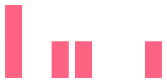
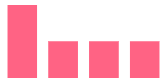
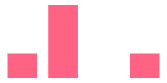
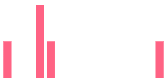
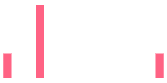
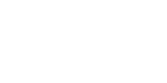
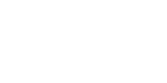
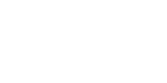
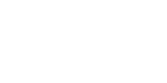
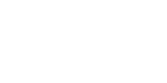

<JupyterRequire.display.SafeScript object>

,S,ASVABC,SM,ETHBLACK,ETHHISP
S,1.000000,0.581025,0.361609,-0.060156,-0.033673
ASVABC,0.581025,1.000000,0.420196,-0.305607,-0.095867
SM,0.361609,0.420196,1.000000,0.008484,-0.321242
ETHBLACK,-0.060156,-0.305607,0.008484,1.000000,-0.080336
ETHHISP,-0.033673,-0.095867,-0.321242,-0.080336,1.000000


In [33]:
df[['S', 'ASVABC', 'SM', 'ETHBLACK', 'ETHHISP']].corr()

In [32]:
result_5 = smf.ols('S ~ ASVABC + SM + ETHBLACK + ETHHISP', df).fit()
result_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     78.74
Date:                Tue, 14 Mar 2023   Prob (F-statistic):           1.67e-52
Time:                        19:13:49   Log-Likelihood:                -1122.1
No. Observations:                 540   AIC:                             2254.
Df Residuals:                     535   BIC:                             2276.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6844      0.527      8.888      0.000       3.649       5.720
ASVABC         0.1430      0.010     13.952      0.000       0.123       0.163
SM             0.1297      0.035      3.734      0.000       0.061       0.198
ETHBLACK       0.9218      0.290      3.179      0.002       0.352       1.492
ETHHISP        0.8523      0.399      2.134      0.033       0.068       1.637
==============================================================================
Omnibus:                       10.084   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.413
Skew:                           0.338   Prob(JB):                      0.00548
Kurtosis:                       2.928   Cond. No.                         355.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Ошибка измерения 
- Еще одной причиной эндогенности является ошибка измерения переменных
- Возможно два случая наличия ошибки измерения:
    - Ошибки в измерениях зависимой переменной
    - Ошибки в измерении независимой переменной

- **Ошибки в измерениях зависимой переменной**
- Допустим, у нас есть истинное значение $y$, но мы наблюдаем величину $y^{*} = y + u$, где $u$ - ошибки, имеющие нулевое мат. ожидание и не зависящие от случайного члена и независимых переменных
- Этот случай очень простой и наша модель превращается в следующее:
$$y^{*} = X\beta + (\varepsilon + u)$$
- Собственно, наши оценки коэффициентов все еще несмещенные и состоятельные, но дисперсия регрессии будет увеличена

- **Ошибки в измерении независимой переменной**
- А вот это случай давайте разберем поподробнее
- Пусть истинная модель выглядит вот так: $y = \alpha + \beta * Z + v$
- Но мы не можем измерить переменную $Z$ абсолютно точно
- Мы можем использовать перменную $X$, которая равна истинному значению $Z$ плюс ошибка измерения $w$: $X = Z + w$
- Опять предположим, что $w$ имеет нулевое мат. ожидание и дисперсию $\sigma^2_w$, что $Z$ имеет теоретическую дисперсию $\sigma^2_z$ и что $w$ распределено независимо от $Z$ и $v$
- Тогда, подставим вместе $Z$ выражение с $X$: $y = \alpha + \beta * (X - w) + v = \alpha + \beta * X + v - \beta*w = \alpha + \beta * X + u$
- Опять вспоминаем формулу для оценки коэффициента: 
$$\hat{\beta} = \frac{cov(X, y)}{var(X)} = \beta + \frac{cov(X, u)}{var(X)} = \beta + \frac{cov((Z + w),(v - \beta*w))}{var(Z + w)} = \beta + \frac{cov(Z, v) + cov(w, v) + cov(Z, -\beta*w) + cov(w, -\beta*w)}{var(Z) + var(w)} = \\ = \beta - \frac{\beta*\sigma^2_w}{\sigma^2_z + \sigma^2_w}$$
- То есть у нас опять возникает проблема смещенности и несостоятельности

### Способы борьбы

- Самый основной способ борьбы с эндогенностью - это использование инструментальных переменных (ИП)
- По сути, применение ИП заключается в том, что мы заменяем непригодные объясняющие переменные, на те, которые коррелируют с этими непригодными объясняющими переменными и не коррелируют со случайным членом
- Давайте на простом примере: $y = \alpha + \beta * X + u$
- Предположим, что $X$ является эндогенной переменной, что приведет к смещенным и несостоятельным оценкам параметрам
- Еще допустим, что есть некая переменная $Z$, которая коррелирована с $X$, но не коррелирована с $u$
- Тогда оценка коэффициента $\beta$ будет равна: $\hat{\beta} = \frac{cov(Z, Y)}{cov(Z, X)} \text{ или в матрицах } (Z'X)^{-1}Z'Y$
- *FFT: попробуйте сами вывести эту оценку*

- Собственно, хорошая инстурментальная переменная должна удовлетворять трем требованиям:
    - Она должна быть скоррелирована с объясняющей переменной, для которой служит инструментом
    - Она не должна быть скоррелирована со случайным членом
    - Она сама не должна быть объясняющей переменной

- Это, конечно, все очень хорошо
- Но как это сделать?
- Давайте посмотрим на примере

- Вспоминаем тот замечательный набор данных с обучением и заработком
- В некоторых наборах данных до 10% дисперсии измеренной продолжительности обучения может быть вызвано ошибками измерения. Соответственно, коэффициент при этой переменной может быть недооценен

In [86]:
model_log_earnings = smf.ols('np.log(EARNINGS) ~ S + EXP', data = df).fit()
model_log_earnings.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(EARNINGS)   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     100.9
Date:                Thu, 10 Sep 2020   Prob (F-statistic):           6.47e-38
Time:                        17:00:49   Log-Likelihood:                -393.37
No. Observations:                 540   AIC:                             792.7
Df Residuals:                     537   BIC:                             805.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5093      0.166      3.061      0.002       0.182       0.836
S              0.1236      0.009     13.583      0.000       0.106       0.141
EXP            0.0351      0.005      7.010      0.000       0.025       0.045
==============================================================================
Omnibus:                       14.231   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               24.612
Skew:                           0.150   Prob(JB):                     4.52e-06
Kurtosis:                       4.002   Cond. No.                         170.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Давайте подумаем, какую переменную можно использовать в качестве инструментальной для переменной продолжительности обучения `S`
- Например, есть переменная `SM`, которая коррелирована с переменной `S`, но навряд ли коррелирует с ошибкой модели

In [17]:
from statsmodels.sandbox.regression.gmm import IV2SLS   

In [4]:
df['const'] = 1

In [29]:
iv_reg = IV2SLS(endog=np.log(df['EARNINGS']), 
                exog = pd.concat([df['const'], df['EXP'], df['S']], axis = 1), 
                instrument=pd.concat([df['const'], df['EXP'], df['SM']], axis = 1)).fit()

In [30]:
iv_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:               EARNINGS   R-squared:                       0.251
Model:                         IV2SLS   Adj. R-squared:                  0.249
Method:                     Two Stage   F-statistic:                     28.38
                        Least Squares   Prob (F-statistic):           1.92e-12
Date:                Tue, 09 Mar 2021                                         
Time:                        17:47:33                                         
No. Observations:                 540                                         
Df Residuals:                     537                                         
Df Model:                           2                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0617      0.406     -0.152      0.879      -0.860       0.736
EXP            0.0394      0.006      6.790      0.000       0.028       0.051
S              0.1600      0.025      6.328      0.000       0.110       0.210
==============================================================================
Omnibus:                       11.953   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               21.305
Skew:                           0.066   Prob(JB):                     2.36e-05
Kurtosis:                       3.964   Cond. No.                         170.
==============================================================================
"""

In [5]:
s_hat = smf.ols('S~SM', data = df).fit()

In [6]:
s_hat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      S   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     80.93
Date:                Tue, 09 Mar 2021   Prob (F-statistic):           3.99e-18
Time:                        17:25:22   Log-Likelihood:                -1209.2
No. Observations:                 540   AIC:                             2422.
Df Residuals:                     538   BIC:                             2431.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0469      0.415     24.226      0.000       9.232      10.862
SM             0.3131      0.035      8.996      0.000       0.245       0.381
==============================================================================
Omnibus:                       16.529   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.494
Skew:                           0.441   Prob(JB):                     0.000159
Kurtosis:                       3.001   Cond. No.                         50.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
s_hat.fittedvalues

0      12.551514
1      11.612276
2      13.490752
3      13.803831
4      15.056149
         ...    
535    12.864594
536    14.116911
537    13.803831
538    13.177673
539    13.490752
Length: 540, dtype: float64

In [12]:
exog = pd.concat([df['const'], df['EXP'], s_hat.fittedvalues], axis=1)

In [15]:
sm.OLS(endog=np.log(df['EARNINGS']), exog=exog).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               EARNINGS   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     23.07
Date:                Tue, 09 Mar 2021   Prob (F-statistic):           2.44e-10
Time:                        17:27:29   Log-Likelihood:                -457.22
No. Observations:                 540   AIC:                             920.4
Df Residuals:                     537   BIC:                             933.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2800      0.392      0.714      0.476      -0.490       1.050
EXP            0.0210      0.005      3.824      0.000       0.010       0.032
0              0.1577      0.028      5.705      0.000       0.103       0.212
==============================================================================
Omnibus:                       19.381   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.453
Skew:                           0.356   Prob(JB):                     4.90e-06
Kurtosis:                       3.761   Cond. No.                         356.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Тесты

- Начнем, пожалуй, с одного из наиболее популярных тестов на ... Сложно объяснить одной фразой, поэтому так:
    - Если у нас есть ситуация (например, эндогенность), когда оценки МНК оказываются несостоятельными, то, очевидно, предпочтительнее оценки, полученные с помощью метода инструментальных переменных
    - Однако, если такой ситуации нет (например, эндогенности), то тогда и МНК, и инструментальные перменные дадут состоятельные оценки. Но оценки МНК будут предпочтительнее, т.к. они более эффективные
- Собственно, тест Хаусмана (Hausman, 1978; Durbin, 1954; Wu, 1973) на спецификацию сравнивает оценки двух методов. С его помощью можно сделать вывод о том, что один метод оценивания лучше другого
- Мы предполагаем, что оценки, которые получены двумя разными методами одинаковые, т.е. они систематически не отличаются
- Тогда, разность оценок коэффициентов статистически не должна отличаться от нуля
- Хм, напоминает общий случай линейных ограничений. Конечно, это не то же самое, но логика очень похожа
- Наконец, сама статистика будет выглядеть вот так:
$$H = (\beta_c - \beta_e)'(V_c - V_e)^{-1}(\beta_c - \beta_e)$$
где $\beta_c$ - оценки коэффициентов состоятельного метода (например, при эндогенности, это оценки ИП), $\beta_e$ - оценки коэффициентов эффективного метода (например, при эндогенности, это оценки МНК), $V_c$ - ковариационная матрица состоятельного метода, $V_e$ - ковариационная матрица эффективного метода

In [33]:
iv_reg.spec_hausman()

(2.474133452437337, 0.11573321182665472, 1)

- Соотвественно, наше $p_{value} = 0.116$, значит на 5% уровне значимости мы не можем отвергнуть нашу нулевую гипотезу о том, что оценки коэффициентов систематически не отличаются. Следовательно, мы выбираем более эффективные оценки, т.е. оценки МНК

- А теперь давайте подумаем, какие переменные влияют на заработную плату
- Посмотрим на эти переменные внимательно и подумаем, не являются ли они эндогенными
- Если являются, то подумаем, с помощью каких ИП можно улучшить нашу регрессию
- Протестируем, полученные оценки методом ИП и МНК
- Сделаем выводы

## QA (резюме занятия от вашего лица)

- Что мы сегодня с вами изучили?
- Как вы считаете, чем нам может помочь изученный материал? Где его можно применять?
- Что бы хотели добавить в это занятие или изменить в нем?